In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Uchuu

In [2]:
from src import load_bgs

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
2024-12-03 06:22:35,143 INFO sparse_dot_mkl found. Building hessian should be faster.
2024-12-03 06:22:35,176 INFO loading lemaitre filterlib from /global/homes/a/agillesl/.cache/bbf/lemaitre_flib.default.0b8479e36fca60c99e76ea84d98cbe0c7383608814cddfaef21626fdf668b5c5.pkl
2024-12-03 06:22:36,462 INFO Unable to initialize backend 'cuda': 
2024-12-03 06:22:36,463 INFO Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 06:22:36,464 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-03 06:22:36,465 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
bgs_df = load_bgs(filename='Uchuu_0.2.csv', columns=['RA', 'DEC', 'Z_COSMO', 'Z', 'HALO_ID', 'PID', 'STATUS'], in_desi=False)

2024-12-03 06:22:55,250 INFO Found .csv file at ../../project/Projet-LPNHE/data/Uchuu_0.2.csv with columns Index(['dec', 'ra', 'z_cosmo', 'z', 'status', 'halo_id', 'pid'], dtype='object')


In [ ]:
# to_use=[]
# used_halos = set(bgs_df.halo_id)
# for i in tqdm(range(100)):
#     with h5py.File(file_dir+f'halolist_z0p00_{i}.h5', 'r') as file:
#         # print("Keys: %s"% file.keys())
#         snapshot_id = set(np.int64(file["id"]))
#     if used_halos.intersection(set(snapshot_id)):
#         to_use.append(i)

In [3]:
to_use = np.arange(100)

In [4]:
import h5py

In [5]:
file_dir="/global/cfs/cdirs/desi/mocks/cai/Uchuu-SHAM/Uchuu-halo-catalogs/Uchuu_halo_catalogs/halodir_050/"

In [ ]:
halos=[]
for snap in tqdm(to_use):
    with h5py.File(file_dir+f'halolist_z0p00_{snap}.h5', 'r') as file:
        df = pandas.DataFrame({k:file[k] for k in ["x", "y", "z"]}) #"vx", "vy", "vz", "id"
    halos.append(df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
halos = pandas.concat(halos)

In [24]:
halos['vpec']=((halos.x - 1000)*halos.vx + (halos.y - 1000)*halos.vy + (halos.z - 1000)*halos.vz)/\
                np.sqrt((halos.x - 1000)**2 + (halos.y - 1000)**2 + (halos.z - 1000)**2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection="3d")
                      )
ax.scatter(halos[::100000].x, halos[::100000].y, halos[::100000].z, marker=".", s=.05, alpha=0.1)

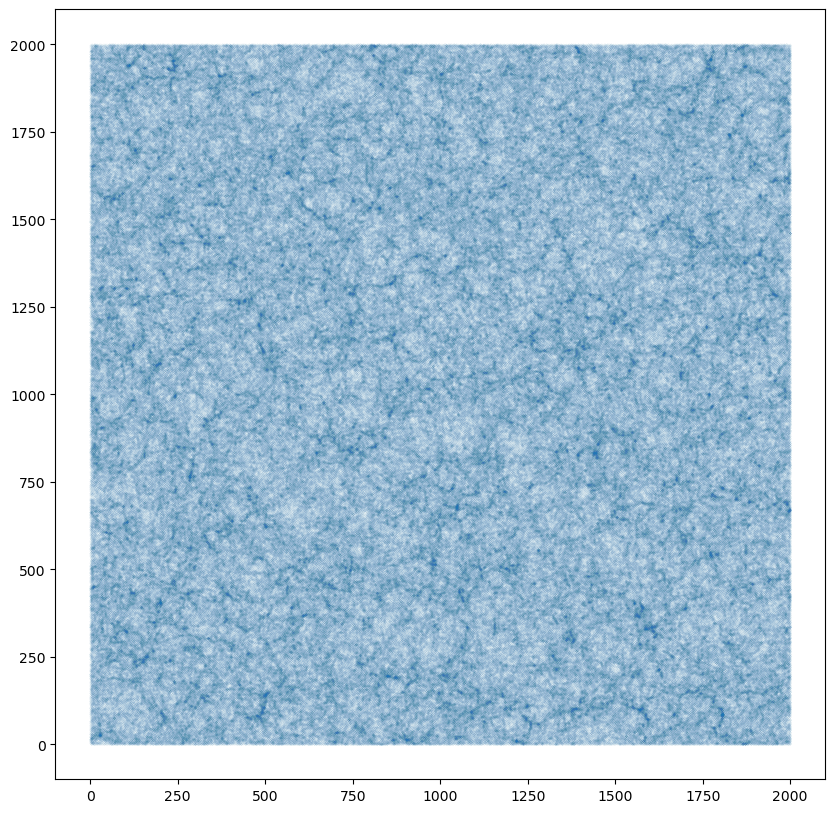

In [12]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(aspect="equal")
                      )
ax.scatter(halos[::100].z, halos[::100].y, marker=".", s=.05, alpha=0.1)


# Abacus

In [1]:
from abacusnbody.data.read_abacus import read_asdf

In [2]:
pid_file="/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_pid_A/halo_pid_A_000.asdf"

In [3]:
file="/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_rv_A/halo_rv_A_000.asdf"
data = read_asdf(file)

In [2]:
import numpy as np

In [3]:
import glob

In [4]:
files = glob.glob("/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_rv_A/*.asdf")

In [5]:
all_pos = np.vstack([read_asdf(filename)["pos"].data for filename in files])

In [6]:
from MAS_library import MA

In [7]:
# density field parameters
grid    = 256    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

In [8]:
all_pos.shape

(4209883445, 3)

In [9]:
MA(all_pos, delta, BoxSize, MAS, verbose=verbose)


Using CIC mass assignment scheme
Time taken = 54.005 seconds



In [10]:
delta /= np.mean(delta, dtype=np.float64)
delta -= 1

In [11]:
import matplotlib.pyplot as plt

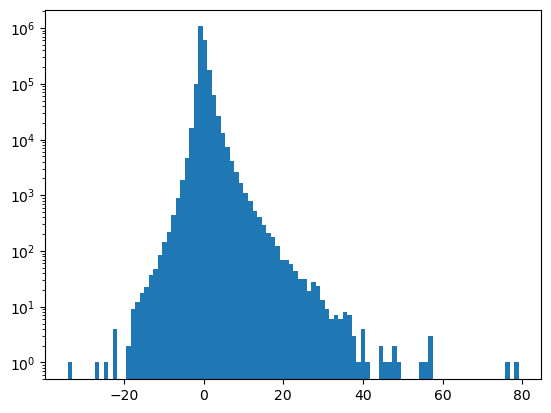

In [12]:
_=plt.hist(delta.flatten(), log=True, bins=100)

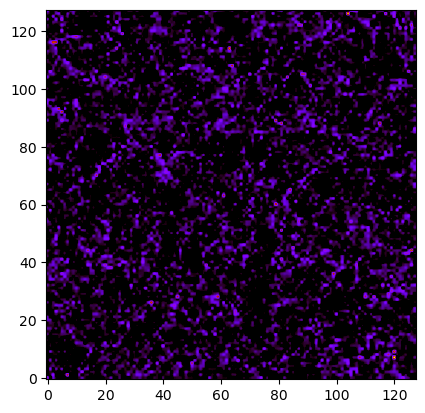

In [18]:
plt.imshow(np.mean(delta[60:70,:,:], axis=0), cmap='gnuplot', vmin=0.0, origin='lower')

In [30]:
X[delta > 0]

array([-500., -500., -500., ...,  500.,  500.,  500.])

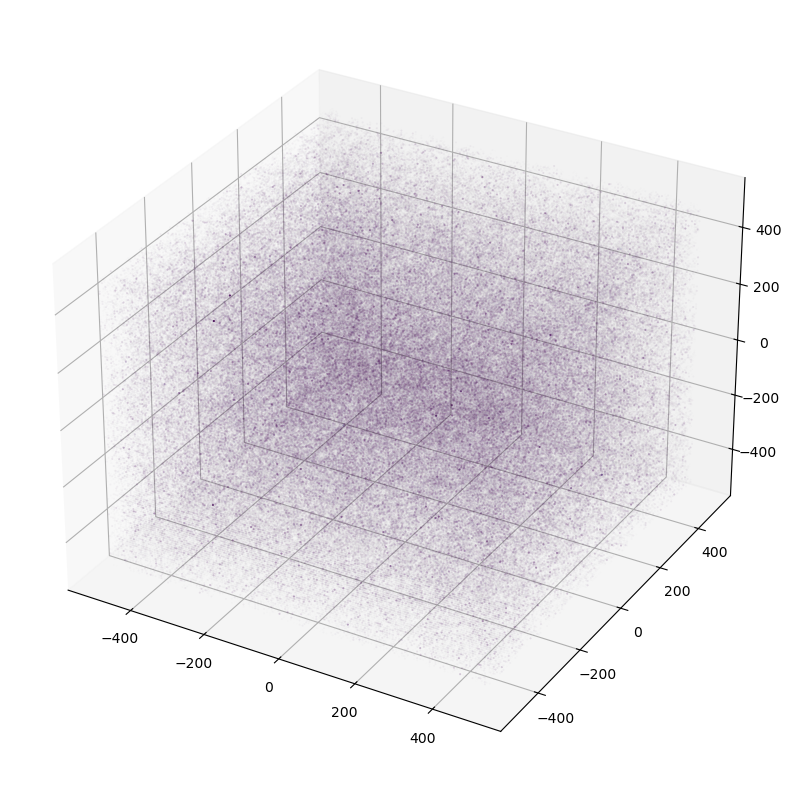

In [36]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":"3d"})
ax.scatter3D(X[delta > 0], Y[delta > 0], Z[delta > 0],
             s=1,
             marker=".",
             c=delta[delta > 0],
             cmap='viridis',
             alpha=delta[delta > 0]/delta.max())